In [ ]:
from dolfin import *
from dolfin_adjoint import *
from numpy import fliplr, linspace, inf, max, ceil
from os.path import join as osjoin
from scipy.io import loadmat as sc_io_loadmat
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors

set_log_level(ERROR) 

class InterpolatedParameter(Expression):
    '''
        Class to get tumor cell distributions by interpolating 
        based off matrices of tumor cell data
    '''
    def __init__(self,X,Y,image,**kwargs):
        self.X = X # A numpy array giving the X-spacing of the image
        self.Y = Y # Same for Y
        self.image = image # The image of measured material property    
    def eval_cell(self,values,x,cell):
        interp_handle = RegularGridInterpolator((self.X,self.Y),self.image)
        values[0] = interp_handle(x)
        
def interp(file_loc,mat_name,norm_factor):
    """
        Function to accept matlab .mat file with tumor data 
        and interpolate values onto mesh
    """
    mat = sc_io_loadmat(file_loc)[mat_name]
    mat = fliplr(mat.T)/norm_factor  # Needs to be adjusted to fit the mesh correctly
    x,y = mat.shape[0], mat.shape[1]
    mat_interp = InterpolatedParameter(linspace(1,x,x),linspace(1,y,y),mat,degree=1)
    return interpolate(mat_interp,V)

def vis_obs(first,second,title1,title2):
    '''
        Compare two quantity plots, for example initial vs. target cellularity
        Accepts titles for each plot
    '''
    cm_jet = cm.get_cmap('jet')
    m = max([first.compute_vertex_values(), second.compute_vertex_values()])
    f = plt.figure()
    
    plt.subplot(1,2,1)
    plt.title(title1)
    c = plot(first,cmap=cm_jet)
    f.colorbar(c, ticks = linspace(0,ceil(m),10))
 
    plt.subplot(1,2,2)
    plt.title(title2)
    c = plot(second,cmap=cm_jet)
    f.colorbar(c, ticks = linspace(0,ceil(m),10))

def set_nonlinear_params(param):
    param['newton_solver']['absolute_tolerance'] = 1E-6
    param['newton_solver']['relative_tolerance'] = 1E-5
    param['newton_solver']['maximum_iterations'] = 51
    param['newton_solver']['relaxation_parameter'] = 1.0
    param['newton_solver']['linear_solver'] = 'gmres'
    param['newton_solver']['preconditioner'] = 'ilu'
    param['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-6
    param['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-5
    param['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
    param['newton_solver']['krylov_solver']['nonzero_initial_guess'] = True

def forward(p_init, name, record=False,  annotate=False):
    """ 
        Here, we define the forward problem with mechanical functions
        
        -E(u) returns the Green-Lagrange strain tensor
        -sigma(...) returns the actual stress tensor
        -sigma_form(...) returns the stress tensor based on 
          the cells (phi), elasticity coefficients, and a 
          coefficient beta 
        -vonmises(...) calculates the von Mises stress based 
          on the actual stress tensor
    """
    global t
    I = Identity(2)  # Identity tensor
    def E(u):
        return 0.5*(nabla_grad(u) + nabla_grad(u).T)
    def vonmises(u):
        s = sigma(u) - (1./2)*tr(sigma(u))*I  # deviatoric stress
        von_Mises = sqrt(3./2*inner(s, s))
        return project(von_Mises, V, annotate=annotate)

    #Set up linear elasticity problem
    U   = VectorFunctionSpace(mesh,'Lagrange',1)
    def boundary(x, on_boundary):
        return on_boundary
    bc  = DirichletBC(U, Constant((0.,0.)), boundary)
    p_n = interpolate(p_init,V)
    v   = TestFunction(U)
    
    parameters['form_compiler']['quadrature_degree'] = 2
    parameters['form_compiler']['cpp_optimize'] = True
    parameters['krylov_solver']['nonzero_initial_guess'] = True
    ffc_options = {"quadrature_degree": 2, 'cpp_optimize': True}
    
    if lin_hyp == 0:
        def sigma(u):
            s = 2*mu*E(u)+lmbda*tr(E(u))*I
            return s
        u    = TrialFunction(U)
        a = inner(2*mu*E(u)+lmbda*tr(E(u))*I,E(v))*dx
        L = inner(2*beta*p_n*I*(mu+lmbda),E(v))*dx
        u    = Function(U, annotate=annotate)
        def mech():
            solve(a == L, u, bc, 
                      form_compiler_parameters=ffc_options,
                      annotate=annotate)
            return u
    else:
        def sigma(u):
            F = I + grad(u)             # Deformation gradient
            B = F*F.T
            C = F.T*F
            J = det(F)
            I1 = tr(C)
            s = lmbda*(J-1)*I+mu*(B-1./2*I1*I)/(J**(5./3))
            return s
        def sigma_form(u, phi):
            F = I + grad(u)             # Deformation gradient
            Fs = F/(1+beta*phi)
            Bs = Fs*Fs.T
            Js  = det(Fs)
            return 1/(1+beta*phi)*(mu/(Js**(5./3))*(Bs-1./2*tr(Bs)*I)+lmbda*(Js-1)*I)
        
        u           = Function(U, annotate=annotate)
        du          = TrialFunction(U)
        F_HE        = inner(sigma_form(u, p_n), E(v))*dx
        J_HE        = derivative(F_HE,u,du)
        problem_HE  = NonlinearVariationalProblem(F_HE, u, bc,
                                      J=J_HE,
                                      form_compiler_parameters=ffc_options)
        solver_HE   = NonlinearVariationalSolver(problem_HE)
        param_HE = solver_HE.parameters
        set_nonlinear_params(param_HE)
        def mech():
            solver_HE.solve(annotate=annotate)
            return u

    # First iteration solving for displacement, 
    #  and using the von mises stress field for D
    disp = mech()
    vm   = vonmises(disp)
    D    = project(D0*exp(-gammaD*vm),V,annotate=annotate)
            
    # Set up reaction-diffusion problem
    dp   = TrialFunction(V)
    p    = Function(V,annotate=annotate)
    q    = TestFunction(V)
    F_RD = (1/dt)*(p - p_n)*q*dx + D*dot(grad(q),grad(p))*dx - k*p*(1 - p)*q*dx  
    J_RD = derivative(F_RD,p,dp) 
    
    for n in range(num_steps):
        # Solve reaction diffusion
        t += dt
        problem_RD  = NonlinearVariationalProblem(F_RD, p,
                                                  J=J_RD,
                                                  form_compiler_parameters=ffc_options)
        solver_RD   = NonlinearVariationalSolver(problem_RD)
        param_RD = solver_RD.parameters
        set_nonlinear_params(param_RD)
        solver_RD.solve(annotate=annotate)
        p_n.assign(p)
   
        # Solve for displacement and vonmises stress
        disp = mech()
        vm   = vonmises(disp)
        D    = project(D0*exp(-gammaD*vm),V,annotate=annotate)
        
    return p

# Callback function for the optimizer
# Writes intermediate results to a logfile
def eval_cb(j, m):
    """ The callback function keeping a log """
    print("objective = %15.10e \n" % j)

def objective(p, target_p, r_coeff1, r_coeff2):
    return assemble(inner(p-target_p, p-target_p)*dx) + \
           r_coeff1*assemble(k*k*dx) + \
           r_coeff2*assemble(dot(grad(k),grad(k))*dx)

def optimize():
    # Define the control
    #m = [Control(D0), Control(gammaD), Control(k), Control(beta)]
    m = [Control(D0), Control(k)]
    
    # Execute first time to annotate and record the tape
    p = forward(p_init, 'annt', False, True)

    Obj = objective(p, p_true, r_coeff1, r_coeff2)

    # Prepare the reduced functional
    rf = ReducedFunctional(Obj,m,eval_cb_post=eval_cb)
    
    # upper and lower bound for the parameter field
    D_lb = 0.
    D_ub = 5.
    k_lb, k_ub = Function(V,annotate=False), Function(V,annotate=False)
    k_lb.vector()[:] = 0.
    k_ub.vector()[:] = 5.
    #gD_lb = .01
    #gD_ub = 1.
    #beta_lb = 0.01
    #beta_ub = 1.
    #bnds = [[D_lb, gD_lb, k_lb, beta_lb],[D_ub, gD_ub, k_ub, beta_ub]]
    bnds = [[D_lb, k_lb],[D_ub, k_ub]]

    # Run the optimization
    m_opt = minimize(rf,
                     method='L-BFGS-B',
                     bounds=bnds, 
                     options={"disp":1,
                              "gtol":2.0e-4,
                              "ftol":2.0e-4,
                              "maxiter":100,
                              "maxls": 15})
    
    return m_opt

#########################################################################
# MAIN 
########################################################################

# Prepare a mesh
input_dir  = "../rat-data/rat05/"
mesh = Mesh(input_dir+"gmsh.xml")
V    = FunctionSpace(mesh, 'CG', 1)

file_results = XDMFFile('./output/he_verify_params0.xdmf')
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

# Model parameters
lin_hyp   = 0
t         = 0.           # initial time 
T         = 2            # final time 
num_steps = T*10         # number of time steps
dt        = T/float(num_steps)  # time step size
theta     = 50970.       # carrying capacity - normalize cell data by this 
mu        = .42          # kPa, bulk shear modulus
nu        = .45
lmbda     = 2*mu*nu/(1-2*nu)
gammaD    = .5
beta      = .5
r_coeff1  = 0.0005
r_coeff2  = 0.1
D_true    = 0.

# Prepare values for forward model
D0     = Constant(D_true)
k_true = interp("../rat-data/k_synth.mat","k",1)
k      = k_true

# Load initial tumor condition data and run forward model
p_init = interp(input_dir+"tumor_t0.mat","tumor", theta)
p_init.rename('initial','tumor at day 0')
p_true  = forward(p_init, 'forward', record=False,  annotate=False)
annotate=False

# Initial guesses
D0     = Constant(1.)
k      = project(Constant(1.),V,annotate=False)     # growth rate initial guess

# Optimization 
[D_est, k_est] = optimize() # optimize these params using the adjoint method provided by adjoint_dolfin
t = 0
D0, k = D_est, k_est
p_est = forward(p_init, 'forward', record=False,  annotate=False)

print('D0 estimated     = '+str(D0.values()[0]))
print('J_opt            = '+str(objective(p_est, p_true, r_coeff1, r_coeff2)))
print('J_opt (no reg)   = '+str(objective(p_est, p_true, 0., 0.)))

p_true.rename('p_true','p_true field')   
p_est.rename('p_est','p_est field') 
k_true.rename('k_true','k_true field')   
k_est.rename('k_est','k_est field')   
file_results.write(p_true,0.)
file_results.write(p_est,0.)
file_results.write(k_true,0.)
file_results.write(k_est,0.)
    
vis_obs(p_true,p_est,'synthetic','estimated')
vis_obs(k_true,k_est,'synthetic','estimated')
    


In [5]:

file_results = XDMFFile('./output/le_verify_params3.xdmf')
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True
p_true.rename('p_true','p_true field')   
p_est.rename('p_est','p_est field') 
k_true.rename('k_true','k_true field')   
k_est.rename('k_est','k_est field')   
file_results.write(p_true,0.)
file_results.write(p_est,0.)
file_results.write(k_true,0.)
file_results.write(k_est,0.)

# Appendix
## A. Sensitivity test of $\beta$ for linear elasticity
After running a few parameter estimates with different true values of $\beta$ such as .02 and .5, the estimated values returned were off and high, such as .78 and 1, respectively. It was hypothesized that this parameter might not have a significant effect on the results. A sensitivity analysis was conducted to determine whether this parameter should be estimated or whether a default value could be used. The code below tests various values of $\beta$ and it is shown that even with values different by 4 orders of magnitude, tumor growth at several days is not very different. Area, as estimated by number of pixels with cell count greater than .1, is similar as can be seen.

Volume when beta = .0001 is 1405
Volume when beta = 1. is 1273


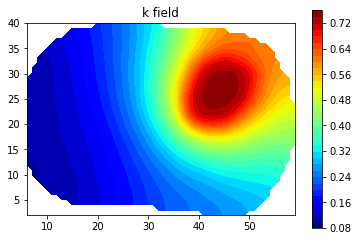

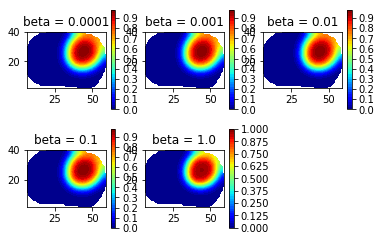

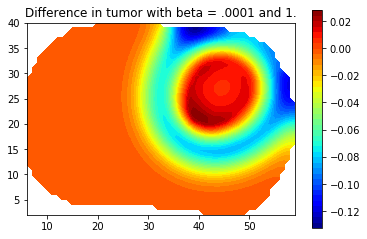

In [18]:
t = 0
D0 = D_est
k = k_est/2
lin_hyp   = 0
t         = 0.           # initial time 
T         = 7            # final time 
num_steps = T*10         # number of time steps
dt        = T/float(num_steps)  # time step size
estimated = []
cm_jet = cm.get_cmap('jet')
    
f = plt.figure()
plt.title("k field")
c = plot(k, cmap=cm_jet)
f.colorbar(c)

f = plt.figure()
for idx, beta in enumerate([0.0001, 0.001, 0.01, .1, 1.]):
    plt.subplot(2,3,idx+1)
    plt.title("beta = "+str(beta))
    estimated.append(forward(initial_p, 'forward', record=False,  annotate=False))
    c = plot(estimated[idx], cmap=cm_jet)
    f.colorbar(c)

f = plt.figure()
plt.title("Difference in tumor with beta = .0001 and 1.")
p_diff = estimated[-1]-estimated[0]
c = plot(p_diff, cmap=cm_jet)
f.colorbar(c)
print("Volume when beta = .0001 is " +str(sum(estimated[0].compute_vertex_values() > 0.1)))
print("Volume when beta = 1. is " +str(sum(estimated[-1].compute_vertex_values() > 0.1)))

## B. Sensitivity test of $\gamma_D$ for linear elasticity
After running a few parameter estimates with different true values of $\gamma_D$, the estimated values returned were off and high similar to with $\beta$. It was hypothesized that this parameter might not have a significant effect on the results. A sensitivity analysis was conducted to determine whether this parameter should be estimated or whether a default value could be used. The code below tests various values of $\gamma_D$ and it is shown that even with values different by 4 orders of magnitude, tumor growth at several days is not very different. Area, as estimated by number of pixels with cell count greater than .1, is similar as can be seen.

Volume when gammaD = .0001 is 1314
Volume when gammaD = 1. is 1255


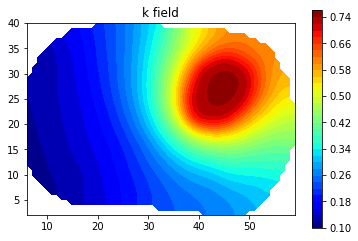

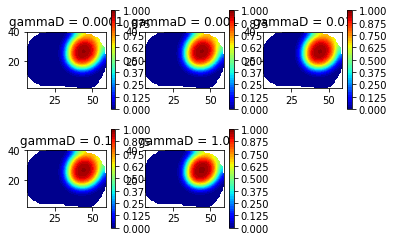

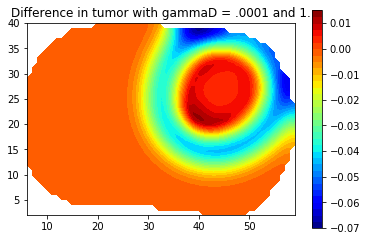

In [22]:
t = 0
D0 = D_est
k = k_est/2
lin_hyp   = 0
t         = 0.           # initial time 
T         = 7            # final time 
num_steps = T*10         # number of time steps
dt        = T/float(num_steps)  # time step size
estimated = []
cm_jet = cm.get_cmap('jet')
    
f = plt.figure()
plt.title("k field")
c = plot(k, cmap=cm_jet)
f.colorbar(c)

f = plt.figure()
for idx, gammaD in enumerate([0.0001, 0.001, 0.01, .1, 1.]):
    plt.subplot(2,3,idx+1)
    plt.title("gammaD = "+str(gammaD))
    estimated.append(forward(initial_p, 'forward', record=False,  annotate=False))
    c = plot(estimated[idx], cmap=cm_jet)
    f.colorbar(c)

f = plt.figure()
plt.title("Difference in tumor with gammaD = .0001 and 1.")
p_diff = estimated[-1]-estimated[0]
c = plot(p_diff, cmap=cm_jet)
f.colorbar(c)
print("Volume when gammaD = .0001 is " +str(sum(estimated[0].compute_vertex_values() > 0.1)))
print("Volume when gammaD = 1. is " +str(sum(estimated[-1].compute_vertex_values() > 0.1)))